In [2]:
import torch
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
muscle_parameters = {
    "lmin": 0.24,
    "lmax": 1.53,
    "fvman": 1.38,
    "fpmax": 1.76,
    "fmin": 0.1,
    "lce_max": 1.0,
    "peak_force": 34,
    "eps": 10e-6,
    "dt":0.002,
    "num_envs": 1,
    "num_joints": 12,
    "device": "cuda",
    "angles": torch.Tensor([[-1.0472, 1.0472], [-1.0472, 1.0472], [-1.0472, 1.0472], [-1.0472, 1.0472], [-1.5708, 3.4907], [-1.5708, 3.4907], [-0.5236, 4.5379], [-0.5236, 4.5379], [-2.7227, -0.8378], [-2.7227, -0.8378], [-2.7227, -0.8378], [-2.7227, -0.8378]])
}

In [7]:
from __future__ import annotations
import torch

from scipy.optimize import bisect

class MuscleActuator:
    def __init__(self, muscle_params, *args, **kwargs):
        
        self.muscle_params = muscle_params

        for key, value in self.muscle_params.items():
            setattr(self, key, value)

        for key, value in kwargs:
            setattr(self, key, value)

        self.phi_min = self.angles[:, 0]
        
        self.phi_max = self.angles[:, 1]

        self.activation_tensor = torch.zeros(
            (self.num_envs, self.num_joints * 2),
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )

        self.lce_tensor = torch.zeros(
            (self.num_envs, self.num_joints * 2),
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )
        self.lce_dot_tensor = torch.zeros(
            (self.num_envs, self.num_joints * 2),
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )
        self.force_tensor = torch.zeros(
            (self.num_envs, self.num_joints * 2),
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )
        self.lce_1_tensor = torch.zeros(
            (self.num_envs, self.num_joints),
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )
        self.lce_2_tensor = torch.zeros(
            (self.num_envs, self.num_joints),
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )
        self.moment, self.lce_ref = self._compute_parametrization()

    def _FL(self, lce: torch.Tensor) -> torch.Tensor:
        """
        Force length
        """
        length = lce
        b1 = self._bump(length, self.lmin, 1, self.lmax)
        b2 = self._bump(length, self.lmin, 0.5 * (self.lmin + 0.95), 0.95)
        bump_res = b1 + 0.15 * b2
        return bump_res
    
    def _calc_l_min(self, Fmin, tol=10e-7):
        def f(l_ce):
            return self._FL(torch.tensor([l_ce], device=self.device)) - Fmin
        
        mid = 1.0
        return bisect(lambda x: f(x), self.lmin + 10e-9, mid - 10e-9, xtol=tol)

    def _bump(self, length: torch.Tensor, A: float, mid: float, B: float) -> torch.Tensor:
        """
        skewed bump function: quadratic spline
        Input:
            :length: tensor of muscle lengths [Nenv, Nactuator]
            :A: scalar
            :mid: scalar
            :B: scalar

        Returns:
            :torch.Tensor: contains FV result [Nenv, Nactuator]
        """

        left = 0.5 * (A + mid)
        right = 0.5 * (mid + B)
        # Order of assignment needs to be inverse to the if-else-clause case
        bump_result = torch.ones(
            (self.num_envs, self.num_joints * 2),
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )

        x = (B - length) / (B - right)
        bump_result = 0.5 * x**2

        x = (length - mid) / (right - mid)
        bump_result = torch.where(length < right, 1 - 0.5 * x**2, bump_result)

        x = (mid - length) / (mid - left)
        bump_result = torch.where(length < mid, 1 - 0.5 * x**2, bump_result)

        x = (length - A) / (left - A)
        bump_result = torch.where((length < left) & (length > A), 0.5 * x**2, bump_result)

        bump_result = torch.where(
            torch.logical_or((length <= A), (length >= B)),
            torch.tensor([0], dtype=torch.float32, device=self.device),
            bump_result,
        )
        return bump_result
    
    def _compute_parametrization(self):
        """
        Find parameters for muscle length computation.
        This should really only be done once...

        We compute them as one long vector now.
        """

        self.lce_min = self._calc_l_min(self.fmin)
        print(self.lce_min)

        moment = torch.zeros((self.num_envs, self.num_joints * 2))
        moment[:, : int(moment.shape[1] // 2)] = (self.lce_max - self.lce_min) / (self.phi_max - self.phi_min)
        moment[:, int(moment.shape[1] // 2) :] = (self.lce_max - self.lce_min) / (self.phi_min - self.phi_max)
        lce_ref = torch.zeros((self.num_envs, self.num_joints * 2))
        lce_ref[:, : int(lce_ref.shape[1] // 2)] = self.lce_min - moment[:, : int(moment.shape[1] // 2)] * self.phi_min
        lce_ref[:, int(lce_ref.shape[1] // 2) :] = self.lce_min - moment[:, int(moment.shape[1] // 2) :] * self.phi_max
        return moment, lce_ref

In [11]:
muscle_parameters['fmin'] = 0.05
ma = MuscleActuator(muscle_parameters)


0.3325045470554161


In [6]:
joint_names = ['FL_hip_joint', 'FR_hip_joint', 'RL_hip_joint', 'RR_hip_joint', 'FL_thigh_joint', 'FR_thigh_joint', 'RL_thigh_joint', 'RR_thigh_joint', 'FL_calf_joint', 'FR_calf_joint', 'RL_calf_joint', 'RR_calf_joint']

lengths = torch.linspace(muscle_parameters['lmin'], muscle_parameters['lmax'], 10000)
forces = [ma._FL(torch.tensor([length], device=muscle_parameters['device'])).cpu().numpy() for length in lengths]


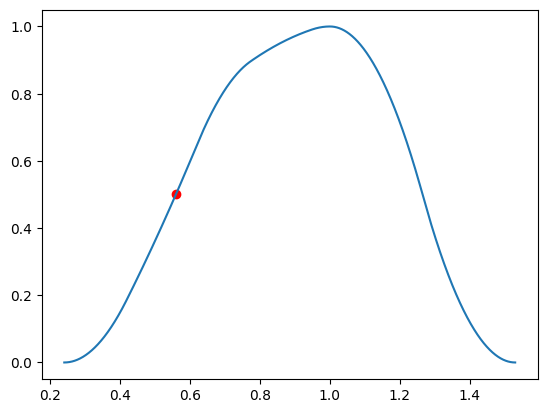

In [10]:
plt.plot(lengths.cpu().numpy(), forces)
plt.scatter(x=ma.lce_min, y=muscle_parameters['fmin'], color='red')